In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import os

#tensorflow keras imports
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
Num GPUs Available:  4


In [3]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [4]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [41]:
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    mu_t2 = 0.
    sd_m = 0.
    sd_t = 0.
    sd_t2 = 0.
    
    mj1_list = []
    mj2_list = []

    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qq in ['qq','qqq']:

                print("on ...",m1,m2,qq)

                ltau1_m_m = []
                ltau2_m_m = []
                ltau3_m_m = []
                stau1_m_m = []
                stau2_m_m = []
                stau3_m_m = []
                if (m1>0 and m2>0):
                    myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    if (qq=='qqq'):
                        myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qqq/LHCO_RnD_qqq2_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    jets_m_m = []
                    for line in myfile:
                        jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                        pass
                    ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                    sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                    lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                    smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.
                    
                    #check ordering of the leading and subleading jets
                    #if leading jet mm > subleading, continue
                    #if leading jet mm < subleading, swap
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]

                    ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    ltau3_m_m = np.array([float(ljet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    stau3_m_m = np.array([float(sjet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    mjj = computemjj_txt(jets_m_m)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]
                    pass
                elif m1==0 and m2==0:
                    df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                    lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                    smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                    
                    #check jet ordering
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                    ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                    ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                    ltau3_m_m = np.array(df_QCD[["tau3j1"]]).flatten()
                    stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                    stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                    stau3_m_m = np.array(df_QCD[["tau3j2"]]).flatten()
                    mjj = computemjj_pd(df_QCD)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]

                    mu_m = np.mean(lmass_m_m)
                    mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                    mu_t2 = np.mean(ltau3_m_m/(ltau2_m_m+0.0001))
                    sd_m = np.std(lmass_m_m)
                    sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                    sd_t2 = np.std(ltau3_m_m/(ltau2_m_m+0.0001))
                    pass
                else:
                    continue

                ms = np.stack([lmass_m_m,smass_m_m],axis=1)
                ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
                ts2 = np.stack([ltau3_m_m/(ltau2_m_m+0.0001),stau3_m_m/(stau2_m_m+0.001)],axis=1)
                order1 = [np.argmax(ms[i]) for i in range(len(ms))]
                order2 = [np.argmin(ms[i]) for i in range(len(ms))]
                mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
                mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
                
                mj1_list.append(mJ1)
                mj2_list.append(mJ2)
                x[m1,m2,qq] = np.stack([(mJ2 - mu_m)/sd_m,
                                        ((mJ1 - mJ2) - mu_m)/sd_m,
                                        ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                        ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                        ([ts2[i][order2[i]] for i in range(len(ts2))] - mu_t2)/sd_t2,
                                        ([ts2[i][order1[i]] for i in range(len(ts2))] - mu_t2)/sd_t2],axis=1)
                lmass_vec[m1,m2]=lmass_m_m
                pass
            pass
        pass
    
    x_array = []
    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array+=[x[m1,m2,qq]]

on ... 0 0 qq
on ... 0 0 qqq
on ... 0 0.5 qq
on ... 0 0.5 qqq
on ... 0 1 qq
on ... 0 1 qqq
on ... 0 1.5 qq
on ... 0 1.5 qqq
on ... 0 2 qq
on ... 0 2 qqq
on ... 0 2.5 qq
on ... 0 2.5 qqq
on ... 0 3 qq
on ... 0 3 qqq
on ... 0 3.5 qq
on ... 0 3.5 qqq
on ... 0 4 qq
on ... 0 4 qqq
on ... 0 4.5 qq
on ... 0 4.5 qqq
on ... 0 5 qq
on ... 0 5 qqq
on ... 0 5.5 qq
on ... 0 5.5 qqq
on ... 0 6 qq
on ... 0 6 qqq
on ... 0.5 0 qq
on ... 0.5 0 qqq
on ... 0.5 0.5 qq
on ... 0.5 0.5 qqq
on ... 0.5 1 qq
on ... 0.5 1 qqq
on ... 0.5 1.5 qq
on ... 0.5 1.5 qqq
on ... 0.5 2 qq
on ... 0.5 2 qqq
on ... 0.5 2.5 qq
on ... 0.5 2.5 qqq
on ... 0.5 3 qq
on ... 0.5 3 qqq
on ... 0.5 3.5 qq
on ... 0.5 3.5 qqq
on ... 0.5 4 qq
on ... 0.5 4 qqq
on ... 0.5 4.5 qq
on ... 0.5 4.5 qqq
on ... 0.5 5 qq
on ... 0.5 5 qqq
on ... 0.5 5.5 qq
on ... 0.5 5.5 qqq
on ... 0.5 6 qq
on ... 0.5 6 qqq
on ... 1 0 qq
on ... 1 0 qqq
on ... 1 0.5 qq
on ... 1 0.5 qqq
on ... 1 1 qq
on ... 1 1 qqq
on ... 1 1.5 qq
on ... 1 1.5 qqq
on ... 1 2 qq
on ... 1

In [3]:
#np.save("x_array_qqq",x_array)

In [30]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

In [3]:
qq = "qq"
def load_data(filename, noise_dims):

    mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
    x = {}
    x_array_read = np.load(filename,allow_pickle=True)
    mycounter = -1
    for m1 in mass_range:
        for m2 in mass_range:
            for qqq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                mycounter+=1
                x[m1,m2,qqq, False] = x_array_read[mycounter]

                if noise_dims:
                    qq = "qq"
                    for i in range(noise_dims):
                        noise_feature = np.random.normal(0, 1, len(x[m1,m2,qq, False])).reshape(-1, 1)
                        if i == 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, False], noise_feature))
                        if i > 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, True], noise_feature))
    
    return x
            
x = load_data("x_array_qqq.npy", noise_dims = 0)

In [28]:
np.shape(x[0,0, qq, True])

(121352, 16)

In [4]:
np.shape(x[0,0, qq, False])

(121352, 6)

In [13]:
np.shape(x[0,0, qqq, False])

(121352, 6)

In [31]:
x_data_qq = []
y_data_qq = []

noise = False
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        for qq in ['qq']:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0,qq, noise],m1*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2,qq, noise],m1*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_data_qq = np.concatenate([x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_data_qq = np.concatenate([x_data_qq,x_aug_0,x_aug_m])
                y_data_qq = np.concatenate([y_data_qq,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [32]:
# np.save("x_parametrized_data_qq", x_data_qq)
# np.save("y_parametrized_data_qq", y_data_qq)

In [4]:
x_data_qq = np.load("x_parametrized_data_qq.npy")
y_data_qq = np.load("y_parametrized_data_qq.npy")

In [39]:
np.shape(x_data_qq)

(27249420, 18)

In [5]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_data_qq, y_data_qq, test_size=0.5, random_state = 42)

In [15]:
X_train_qq

array([[-1.48810434, -1.16227514,  0.60044972, ...,  0.20710892,
         2.        ,  1.        ],
       [-1.53912995, -0.79811617,  0.77186551, ...,  0.3935544 ,
         4.        ,  4.5       ],
       [-1.11840745, -0.47890791, -1.41957678, ...,  0.07912354,
         1.        ,  3.        ],
       ...,
       [-1.10571607, -1.24210061,  1.24483233, ..., -0.59226963,
         5.5       ,  1.5       ],
       [-0.36430182, -1.17494904, -0.70482558, ..., -0.11373078,
         3.5       ,  6.        ],
       [-0.55182417, -1.71658386, -0.56739691, ...,  0.82031277,
         5.5       ,  1.        ]])

In [6]:
x_data_qqq = np.load("x_data_qqq.npy")
y_data_qqq = np.load("y_data_qqq.npy")

In [383]:
np.shape(x_data_qq)

(27249420, 8)

In [8]:
import wandb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from wandb.keras import WandbCallback


pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

config = {
    "layer_1_neurons": 256,
    "layer_2_neurons": 256,
    "layer_3_neurons": 256,
    "output_neurons": 1,
    "activation": "swish",
    "output_activation": "sigmoid",
    "optimizer": "adam",
    "learning_rate": 0.00001,
    "loss": "binary_crossentropy",
    "epochs": 5000,
    "batch_size": 5 * 1024
}

wandb.init(project="SemiWeakly", 
           group="Parametrized", 
           entity='gup-singh', 
           mode = 'online',
           config=config)

config = wandb.config

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def train_parametrized(X_train, Y_train, X_val, Y_val, config):
    model_parametrized = Sequential()
    model_parametrized.add(Dense(config["layer_1_neurons"], input_dim=np.shape(X_train_qq)[1], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_2_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_3_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config.output_neurons, activation=config["output_activation"]))
    model_parametrized.compile(loss=config["loss"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]), metrics=['accuracy'])

    with tf.device('/GPU:0'):
        history_parametrized = model_parametrized.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), batch_size=config.batch_size, callbacks=[es, WandbCallback()])
    return model_parametrized

train_parametrized(X_train_qq, Y_train_qq, X_val_qq, Y_val_qq, config)
    
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5000


2024-01-29 15:46:38.622750: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2654/2662 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9059INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 17s 5ms/step - loss: 0.2451 - accuracy: 0.9060 - val_loss: 0.2019 - val_accuracy: 0.9242
Epoch 2/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1923 - accuracy: 0.9273INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1922 - accuracy: 0.9273 - val_loss: 0.1832 - val_accuracy: 0.9301
Epoch 3/5000
2656/2662 [============================>.] - ETA: 0s - loss: 0.1777 - accuracy: 0.9316INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1777 - accuracy: 0.9316 - val_loss: 0.1721 - val_accuracy: 0.9335
Epoch 4/5000
2654/2662 [============================>.] - ETA: 0s - loss: 0.1689 - accuracy: 0.9345INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 13s 5ms/step - loss: 0.1689 - accuracy: 0.9345 - val_loss: 0.1655 - val_accuracy: 0.9359
Epoch 5/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1634 - accuracy: 0.9366INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1634 - accuracy: 0.9366 - val_loss: 0.1613 - val_accuracy: 0.9376
Epoch 6/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9381INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1596 - accuracy: 0.9381 - val_loss: 0.1577 - val_accuracy: 0.9391
Epoch 7/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1567 - accuracy: 0.9393INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1567 - accuracy: 0.9393 - val_loss: 0.1551 - val_accuracy: 0.9401
Epoch 8/5000
2654/2662 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9403INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1543 - accuracy: 0.9403 - val_loss: 0.1530 - val_accuracy: 0.9409
Epoch 9/5000
2657/2662 [============================>.] - ETA: 0s - loss: 0.1524 - accuracy: 0.9411INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1524 - accuracy: 0.9411 - val_loss: 0.1513 - val_accuracy: 0.9416
Epoch 10/5000
2657/2662 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9417INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1507 - accuracy: 0.9417 - val_loss: 0.1497 - val_accuracy: 0.9423
Epoch 11/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9423INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1492 - accuracy: 0.9423 - val_loss: 0.1483 - val_accuracy: 0.9427
Epoch 12/5000
2654/2662 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.9428INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1480 - accuracy: 0.9428 - val_loss: 0.1471 - val_accuracy: 0.9432
Epoch 13/5000
2650/2662 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9432INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1468 - accuracy: 0.9432 - val_loss: 0.1461 - val_accuracy: 0.9435
Epoch 14/5000
2660/2662 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9436INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1458 - accuracy: 0.9436 - val_loss: 0.1450 - val_accuracy: 0.9440
Epoch 15/5000
2647/2662 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9439INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.9s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1450 - accuracy: 0.9439 - val_loss: 0.1444 - val_accuracy: 0.9442
Epoch 16/5000
2656/2662 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9442INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 18s 7ms/step - loss: 0.1442 - accuracy: 0.9442 - val_loss: 0.1436 - val_accuracy: 0.9445
Epoch 17/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9445INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.5s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1435 - accuracy: 0.9445 - val_loss: 0.1429 - val_accuracy: 0.9448
Epoch 18/5000
2655/2662 [============================>.] - ETA: 0s - loss: 0.1428 - accuracy: 0.9447INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.6s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1429 - accuracy: 0.9447 - val_loss: 0.1423 - val_accuracy: 0.9450
Epoch 19/5000
2656/2662 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9450INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1423 - accuracy: 0.9449 - val_loss: 0.1418 - val_accuracy: 0.9452
Epoch 20/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9451INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.5s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1418 - accuracy: 0.9451 - val_loss: 0.1412 - val_accuracy: 0.9454
Epoch 21/5000
2650/2662 [============================>.] - ETA: 0s - loss: 0.1413 - accuracy: 0.9453INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1413 - accuracy: 0.9453 - val_loss: 0.1408 - val_accuracy: 0.9456
Epoch 22/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1409 - accuracy: 0.9454INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1409 - accuracy: 0.9454 - val_loss: 0.1403 - val_accuracy: 0.9457
Epoch 23/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9456INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.6s


2662/2662 [==============================] - 15s 5ms/step - loss: 0.1405 - accuracy: 0.9456 - val_loss: 0.1399 - val_accuracy: 0.9458
Epoch 24/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1401 - accuracy: 0.9457INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1401 - accuracy: 0.9457 - val_loss: 0.1396 - val_accuracy: 0.9460
Epoch 25/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9458INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1398 - accuracy: 0.9459 - val_loss: 0.1393 - val_accuracy: 0.9461
Epoch 26/5000
2655/2662 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.9460INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1395 - accuracy: 0.9460 - val_loss: 0.1390 - val_accuracy: 0.9462
Epoch 27/5000
2655/2662 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.9461INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1392 - accuracy: 0.9461 - val_loss: 0.1387 - val_accuracy: 0.9463
Epoch 28/5000
2660/2662 [============================>.] - ETA: 0s - loss: 0.1389 - accuracy: 0.9462INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1389 - accuracy: 0.9462 - val_loss: 0.1385 - val_accuracy: 0.9464
Epoch 29/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1387 - accuracy: 0.9463INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1387 - accuracy: 0.9463 - val_loss: 0.1382 - val_accuracy: 0.9465
Epoch 30/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9463INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1384 - accuracy: 0.9463 - val_loss: 0.1379 - val_accuracy: 0.9466
Epoch 31/5000
2654/2662 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9464INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1382 - accuracy: 0.9464 - val_loss: 0.1378 - val_accuracy: 0.9467
Epoch 32/5000
2653/2662 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9465INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1380 - accuracy: 0.9465 - val_loss: 0.1376 - val_accuracy: 0.9467
Epoch 33/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9466INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1378 - accuracy: 0.9466 - val_loss: 0.1373 - val_accuracy: 0.9468
Epoch 34/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9467INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 19s 7ms/step - loss: 0.1376 - accuracy: 0.9467 - val_loss: 0.1371 - val_accuracy: 0.9469
Epoch 35/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1374 - accuracy: 0.9467INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.5s


2662/2662 [==============================] - 15s 5ms/step - loss: 0.1374 - accuracy: 0.9467 - val_loss: 0.1369 - val_accuracy: 0.9470
Epoch 36/5000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1373 - accuracy: 0.9468INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1373 - accuracy: 0.9468 - val_loss: 0.1368 - val_accuracy: 0.9470
Epoch 37/5000
2648/2662 [============================>.] - ETA: 0s - loss: 0.1371 - accuracy: 0.9469INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1371 - accuracy: 0.9469 - val_loss: 0.1366 - val_accuracy: 0.9471
Epoch 38/5000
2651/2662 [============================>.] - ETA: 0s - loss: 0.1370 - accuracy: 0.9469INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 17s 6ms/step - loss: 0.1370 - accuracy: 0.9469 - val_loss: 0.1365 - val_accuracy: 0.9471
Epoch 39/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.9469INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 13s 5ms/step - loss: 0.1368 - accuracy: 0.9469 - val_loss: 0.1363 - val_accuracy: 0.9472
Epoch 40/5000
2651/2662 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9470INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 17s 6ms/step - loss: 0.1366 - accuracy: 0.9470 - val_loss: 0.1362 - val_accuracy: 0.9472
Epoch 41/5000
2656/2662 [============================>.] - ETA: 0s - loss: 0.1365 - accuracy: 0.9471INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1365 - accuracy: 0.9471 - val_loss: 0.1361 - val_accuracy: 0.9473
Epoch 42/5000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1364 - accuracy: 0.9472INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 16s 6ms/step - loss: 0.1364 - accuracy: 0.9472 - val_loss: 0.1360 - val_accuracy: 0.9473
Epoch 43/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9472INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.9s


2662/2662 [==============================] - 15s 5ms/step - loss: 0.1363 - accuracy: 0.9472 - val_loss: 0.1359 - val_accuracy: 0.9473
Epoch 44/5000
2648/2662 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.9472INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1362 - accuracy: 0.9472 - val_loss: 0.1358 - val_accuracy: 0.9474
Epoch 45/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1361 - accuracy: 0.9473INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.6s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1361 - accuracy: 0.9473 - val_loss: 0.1357 - val_accuracy: 0.9474
Epoch 46/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.9473INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 19s 7ms/step - loss: 0.1359 - accuracy: 0.9473 - val_loss: 0.1356 - val_accuracy: 0.9475
Epoch 47/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.9473INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1358 - accuracy: 0.9473 - val_loss: 0.1354 - val_accuracy: 0.9475
Epoch 48/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1358 - accuracy: 0.9473INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1358 - accuracy: 0.9473 - val_loss: 0.1353 - val_accuracy: 0.9476
Epoch 49/5000
2648/2662 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9474INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1356 - accuracy: 0.9474 - val_loss: 0.1352 - val_accuracy: 0.9476
Epoch 50/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9475INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.5s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1356 - accuracy: 0.9475 - val_loss: 0.1352 - val_accuracy: 0.9476
Epoch 51/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.9475INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1355 - accuracy: 0.9475 - val_loss: 0.1350 - val_accuracy: 0.9477
Epoch 52/5000
2656/2662 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9475INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 18s 7ms/step - loss: 0.1354 - accuracy: 0.9475 - val_loss: 0.1350 - val_accuracy: 0.9477
Epoch 53/5000
2651/2662 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9475INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1353 - accuracy: 0.9475 - val_loss: 0.1350 - val_accuracy: 0.9477
Epoch 54/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9476INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 16s 6ms/step - loss: 0.1353 - accuracy: 0.9476 - val_loss: 0.1348 - val_accuracy: 0.9477
Epoch 55/5000
2660/2662 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9476INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1352 - accuracy: 0.9476 - val_loss: 0.1347 - val_accuracy: 0.9478
Epoch 56/5000
2650/2662 [============================>.] - ETA: 0s - loss: 0.1351 - accuracy: 0.9476INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 16s 6ms/step - loss: 0.1351 - accuracy: 0.9476 - val_loss: 0.1347 - val_accuracy: 0.9478
Epoch 57/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1350 - accuracy: 0.9476 - val_loss: 0.1347 - val_accuracy: 0.9478
Epoch 58/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9477INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.8s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1349 - accuracy: 0.9477 - val_loss: 0.1346 - val_accuracy: 0.9478
Epoch 59/5000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9477INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1349 - accuracy: 0.9477 - val_loss: 0.1345 - val_accuracy: 0.9479
Epoch 60/5000
2657/2662 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9477INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1348 - accuracy: 0.9477 - val_loss: 0.1344 - val_accuracy: 0.9479
Epoch 61/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1348 - accuracy: 0.9478 - val_loss: 0.1345 - val_accuracy: 0.9479
Epoch 62/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9477INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1347 - accuracy: 0.9477 - val_loss: 0.1343 - val_accuracy: 0.9479
Epoch 63/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1346 - accuracy: 0.9478INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1346 - accuracy: 0.9478 - val_loss: 0.1343 - val_accuracy: 0.9479
Epoch 64/5000
2654/2662 [============================>.] - ETA: 0s - loss: 0.1346 - accuracy: 0.9478INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.8s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1346 - accuracy: 0.9478 - val_loss: 0.1342 - val_accuracy: 0.9480
Epoch 65/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1345 - accuracy: 0.9478 - val_loss: 0.1342 - val_accuracy: 0.9480
Epoch 66/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9479INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1345 - accuracy: 0.9479 - val_loss: 0.1341 - val_accuracy: 0.9480
Epoch 67/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9479INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.8s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1344 - accuracy: 0.9479 - val_loss: 0.1340 - val_accuracy: 0.9481
Epoch 68/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1344 - accuracy: 0.9479 - val_loss: 0.1340 - val_accuracy: 0.9481
Epoch 69/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1343 - accuracy: 0.9479 - val_loss: 0.1340 - val_accuracy: 0.9481
Epoch 70/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1343 - accuracy: 0.9479INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1343 - accuracy: 0.9479 - val_loss: 0.1339 - val_accuracy: 0.9481
Epoch 71/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9479INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1342 - accuracy: 0.9479 - val_loss: 0.1339 - val_accuracy: 0.9481
Epoch 72/5000
2654/2662 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9480INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.6s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1342 - accuracy: 0.9480 - val_loss: 0.1338 - val_accuracy: 0.9481
Epoch 73/5000
2655/2662 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9479INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1342 - accuracy: 0.9479 - val_loss: 0.1338 - val_accuracy: 0.9481
Epoch 74/5000
2654/2662 [============================>.] - ETA: 0s - loss: 0.1341 - accuracy: 0.9480INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1341 - accuracy: 0.9480 - val_loss: 0.1337 - val_accuracy: 0.9481
Epoch 75/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1341 - accuracy: 0.9480 - val_loss: 0.1338 - val_accuracy: 0.9481
Epoch 76/5000
2648/2662 [============================>.] - ETA: 0s - loss: 0.1340 - accuracy: 0.9480INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 15s 5ms/step - loss: 0.1340 - accuracy: 0.9480 - val_loss: 0.1337 - val_accuracy: 0.9481
Epoch 77/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1340 - accuracy: 0.9480INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1340 - accuracy: 0.9480 - val_loss: 0.1336 - val_accuracy: 0.9482
Epoch 78/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1339 - accuracy: 0.9480 - val_loss: 0.1336 - val_accuracy: 0.9482
Epoch 79/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1339 - accuracy: 0.9480 - val_loss: 0.1337 - val_accuracy: 0.9481
Epoch 80/5000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1339 - accuracy: 0.9481INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1339 - accuracy: 0.9481 - val_loss: 0.1336 - val_accuracy: 0.9481
Epoch 81/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1338 - accuracy: 0.9481INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1338 - accuracy: 0.9481 - val_loss: 0.1334 - val_accuracy: 0.9482
Epoch 82/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1338 - accuracy: 0.9481 - val_loss: 0.1335 - val_accuracy: 0.9482
Epoch 83/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1337 - accuracy: 0.9481INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1337 - accuracy: 0.9481 - val_loss: 0.1334 - val_accuracy: 0.9482
Epoch 84/5000
2653/2662 [============================>.] - ETA: 0s - loss: 0.1337 - accuracy: 0.9481INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1337 - accuracy: 0.9481 - val_loss: 0.1333 - val_accuracy: 0.9483
Epoch 85/5000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1337 - accuracy: 0.9482INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1337 - accuracy: 0.9482 - val_loss: 0.1333 - val_accuracy: 0.9483
Epoch 86/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.9481INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1336 - accuracy: 0.9481 - val_loss: 0.1333 - val_accuracy: 0.9483
Epoch 87/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.9482INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1336 - accuracy: 0.9482 - val_loss: 0.1333 - val_accuracy: 0.9483
Epoch 88/5000
2662/2662 [==============================] - 12s 5ms/step - loss: 0.1336 - accuracy: 0.9482 - val_loss: 0.1333 - val_accuracy: 0.9483
Epoch 89/5000
2648/2662 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9482INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 18s 7ms/step - loss: 0.1335 - accuracy: 0.9482 - val_loss: 0.1332 - val_accuracy: 0.9483
Epoch 90/5000
2662/2662 [==============================] - 12s 5ms/step - loss: 0.1335 - accuracy: 0.9482 - val_loss: 0.1332 - val_accuracy: 0.9483
Epoch 91/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9482INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1335 - accuracy: 0.9482 - val_loss: 0.1332 - val_accuracy: 0.9483
Epoch 92/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9482INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1334 - accuracy: 0.9482 - val_loss: 0.1331 - val_accuracy: 0.9483
Epoch 93/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9482INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 13s 5ms/step - loss: 0.1335 - accuracy: 0.9482 - val_loss: 0.1331 - val_accuracy: 0.9484
Epoch 94/5000
2655/2662 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9482INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1334 - accuracy: 0.9482 - val_loss: 0.1331 - val_accuracy: 0.9483
Epoch 95/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9482INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1334 - accuracy: 0.9482 - val_loss: 0.1330 - val_accuracy: 0.9484
Epoch 96/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1334 - accuracy: 0.9482 - val_loss: 0.1330 - val_accuracy: 0.9484
Epoch 97/5000
2650/2662 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9483INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 10.1s


2662/2662 [==============================] - 24s 9ms/step - loss: 0.1333 - accuracy: 0.9483 - val_loss: 0.1330 - val_accuracy: 0.9484
Epoch 98/5000
2647/2662 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9483INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1333 - accuracy: 0.9483 - val_loss: 0.1330 - val_accuracy: 0.9484
Epoch 99/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9483INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.8s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1333 - accuracy: 0.9483 - val_loss: 0.1329 - val_accuracy: 0.9484
Epoch 100/5000
2652/2662 [============================>.] - ETA: 0s - loss: 0.1332 - accuracy: 0.9483INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.8s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1332 - accuracy: 0.9483 - val_loss: 0.1329 - val_accuracy: 0.9485
Epoch 101/5000
2662/2662 [==============================] - 12s 5ms/step - loss: 0.1332 - accuracy: 0.9483 - val_loss: 0.1329 - val_accuracy: 0.9484
Epoch 102/5000
2662/2662 [==============================] - 12s 5ms/step - loss: 0.1332 - accuracy: 0.9483 - val_loss: 0.1330 - val_accuracy: 0.9484
Epoch 103/5000
2648/2662 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9483INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1332 - accuracy: 0.9483 - val_loss: 0.1328 - val_accuracy: 0.9485
Epoch 104/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1331 - accuracy: 0.9483 - val_loss: 0.1329 - val_accuracy: 0.9485
Epoch 105/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1331 - accuracy: 0.9483 - val_loss: 0.1329 - val_accuracy: 0.9484
Epoch 106/5000
2647/2662 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9483INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1331 - accuracy: 0.9483 - val_loss: 0.1328 - val_accuracy: 0.9485
Epoch 107/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9483INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.6s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1331 - accuracy: 0.9483 - val_loss: 0.1327 - val_accuracy: 0.9485
Epoch 108/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9483INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1331 - accuracy: 0.9483 - val_loss: 0.1327 - val_accuracy: 0.9485
Epoch 109/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9483INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1330 - accuracy: 0.9483 - val_loss: 0.1327 - val_accuracy: 0.9485
Epoch 110/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9484INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.7s


2662/2662 [==============================] - 15s 5ms/step - loss: 0.1330 - accuracy: 0.9484 - val_loss: 0.1327 - val_accuracy: 0.9485
Epoch 111/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9484INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1330 - accuracy: 0.9484 - val_loss: 0.1327 - val_accuracy: 0.9485
Epoch 112/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1330 - accuracy: 0.9484INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1330 - accuracy: 0.9484 - val_loss: 0.1327 - val_accuracy: 0.9485
Epoch 113/5000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9484INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1329 - accuracy: 0.9484 - val_loss: 0.1326 - val_accuracy: 0.9485
Epoch 114/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9484INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 1.3s


2662/2662 [==============================] - 17s 7ms/step - loss: 0.1329 - accuracy: 0.9484 - val_loss: 0.1326 - val_accuracy: 0.9486
Epoch 115/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1329 - accuracy: 0.9484 - val_loss: 0.1326 - val_accuracy: 0.9486
Epoch 116/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1329 - accuracy: 0.9484 - val_loss: 0.1326 - val_accuracy: 0.9486
Epoch 117/5000
2653/2662 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9484INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.9s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1329 - accuracy: 0.9484 - val_loss: 0.1326 - val_accuracy: 0.9486
Epoch 118/5000
2662/2662 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9484INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1328 - accuracy: 0.9484 - val_loss: 0.1325 - val_accuracy: 0.9486
Epoch 119/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1328 - accuracy: 0.9485 - val_loss: 0.1325 - val_accuracy: 0.9486
Epoch 120/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9484INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1328 - accuracy: 0.9484 - val_loss: 0.1325 - val_accuracy: 0.9486
Epoch 121/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1328 - accuracy: 0.9484 - val_loss: 0.1325 - val_accuracy: 0.9486
Epoch 122/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1328 - accuracy: 0.9485 - val_loss: 0.1325 - val_accuracy: 0.9486
Epoch 123/5000
2655/2662 [============================>.] - ETA: 0s - loss: 0.1328 - accuracy: 0.9485INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1327 - accuracy: 0.9485 - val_loss: 0.1324 - val_accuracy: 0.9486
Epoch 124/5000
2653/2662 [============================>.] - ETA: 0s - loss: 0.1327 - accuracy: 0.9485INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1327 - accuracy: 0.9485 - val_loss: 0.1324 - val_accuracy: 0.9486
Epoch 125/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1327 - accuracy: 0.9485 - val_loss: 0.1324 - val_accuracy: 0.9486
Epoch 126/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1327 - accuracy: 0.9485 - val_loss: 0.1324 - val_accuracy: 0.9486
Epoch 127/5000
2661/2662 [============================>.] - ETA: 0s - loss: 0.1327 - accuracy: 0.9485INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 16s 6ms/step - loss: 0.1327 - accuracy: 0.9485 - val_loss: 0.1324 - val_accuracy: 0.9486
Epoch 128/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1326 - accuracy: 0.9485 - val_loss: 0.1324 - val_accuracy: 0.9486
Epoch 129/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9485INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.3s


2662/2662 [==============================] - 16s 6ms/step - loss: 0.1326 - accuracy: 0.9485 - val_loss: 0.1323 - val_accuracy: 0.9487
Epoch 130/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1326 - accuracy: 0.9485 - val_loss: 0.1323 - val_accuracy: 0.9486
Epoch 131/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1326 - accuracy: 0.9485 - val_loss: 0.1323 - val_accuracy: 0.9486
Epoch 132/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9485INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 2.2s


2662/2662 [==============================] - 17s 6ms/step - loss: 0.1326 - accuracy: 0.9485 - val_loss: 0.1323 - val_accuracy: 0.9487
Epoch 133/5000
2657/2662 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9485INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.7s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1326 - accuracy: 0.9485 - val_loss: 0.1323 - val_accuracy: 0.9487
Epoch 134/5000
2654/2662 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9485INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1326 - accuracy: 0.9485 - val_loss: 0.1322 - val_accuracy: 0.9487
Epoch 135/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1325 - accuracy: 0.9485 - val_loss: 0.1323 - val_accuracy: 0.9486
Epoch 136/5000
2648/2662 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9485INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1325 - accuracy: 0.9485 - val_loss: 0.1322 - val_accuracy: 0.9487
Epoch 137/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1325 - accuracy: 0.9486 - val_loss: 0.1323 - val_accuracy: 0.9486
Epoch 138/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1325 - accuracy: 0.9486 - val_loss: 0.1322 - val_accuracy: 0.9487
Epoch 139/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1325 - accuracy: 0.9485 - val_loss: 0.1322 - val_accuracy: 0.9487
Epoch 140/5000
2655/2662 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.9485INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 1.4s


2662/2662 [==============================] - 16s 6ms/step - loss: 0.1325 - accuracy: 0.9485 - val_loss: 0.1322 - val_accuracy: 0.9487
Epoch 141/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1325 - accuracy: 0.9485 - val_loss: 0.1322 - val_accuracy: 0.9487
Epoch 142/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1325 - accuracy: 0.9485 - val_loss: 0.1322 - val_accuracy: 0.9487
Epoch 143/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1324 - accuracy: 0.9485 - val_loss: 0.1322 - val_accuracy: 0.9487
Epoch 144/5000
2658/2662 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9486INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.6s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1324 - accuracy: 0.9486 - val_loss: 0.1321 - val_accuracy: 0.9487
Epoch 145/5000
2650/2662 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9486INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1324 - accuracy: 0.9486 - val_loss: 0.1321 - val_accuracy: 0.9487
Epoch 146/5000
2654/2662 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9486INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 1.1s


2662/2662 [==============================] - 16s 6ms/step - loss: 0.1324 - accuracy: 0.9486 - val_loss: 0.1321 - val_accuracy: 0.9487
Epoch 147/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1324 - accuracy: 0.9486 - val_loss: 0.1322 - val_accuracy: 0.9487
Epoch 148/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1324 - accuracy: 0.9486 - val_loss: 0.1321 - val_accuracy: 0.9487
Epoch 149/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1323 - accuracy: 0.9486 - val_loss: 0.1321 - val_accuracy: 0.9487
Epoch 150/5000
2660/2662 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9486INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1324 - accuracy: 0.9486 - val_loss: 0.1321 - val_accuracy: 0.9487
Epoch 151/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9486INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 15s 5ms/step - loss: 0.1323 - accuracy: 0.9486 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 152/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1323 - accuracy: 0.9486 - val_loss: 0.1321 - val_accuracy: 0.9488
Epoch 153/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1323 - accuracy: 0.9486 - val_loss: 0.1321 - val_accuracy: 0.9487
Epoch 154/5000
2649/2662 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9486INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1323 - accuracy: 0.9486 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 155/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1323 - accuracy: 0.9486 - val_loss: 0.1321 - val_accuracy: 0.9487
Epoch 156/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1323 - accuracy: 0.9486 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 157/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1323 - accuracy: 0.9486 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 158/5000
2655/2662 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9487INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 30.9s


2662/2662 [==============================] - 45s 17ms/step - loss: 0.1322 - accuracy: 0.9487 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 159/5000
2648/2662 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9486INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.4s


2662/2662 [==============================] - 14s 5ms/step - loss: 0.1322 - accuracy: 0.9486 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 160/5000
2662/2662 [==============================] - 12s 5ms/step - loss: 0.1322 - accuracy: 0.9487 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 161/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1322 - accuracy: 0.9486 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 162/5000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9486INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.2s


2662/2662 [==============================] - 15s 6ms/step - loss: 0.1322 - accuracy: 0.9486 - val_loss: 0.1319 - val_accuracy: 0.9488
Epoch 163/5000
2662/2662 [==============================] - 12s 5ms/step - loss: 0.1322 - accuracy: 0.9487 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 164/5000
2647/2662 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9486INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240129_154631-h1zzki1d/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 18s 7ms/step - loss: 0.1322 - accuracy: 0.9487 - val_loss: 0.1319 - val_accuracy: 0.9488
Epoch 165/5000
2662/2662 [==============================] - 12s 5ms/step - loss: 0.1322 - accuracy: 0.9487 - val_loss: 0.1320 - val_accuracy: 0.9488
Epoch 166/5000
2662/2662 [==============================] - 12s 5ms/step - loss: 0.1321 - accuracy: 0.9487 - val_loss: 0.1319 - val_accuracy: 0.9488
Epoch 167/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1321 - accuracy: 0.9487 - val_loss: 0.1319 - val_accuracy: 0.9488
Epoch 168/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1321 - accuracy: 0.9487 - val_loss: 0.1319 - val_accuracy: 0.9488
Epoch 169/5000
2662/2662 [==============================] - 13s 5ms/step - loss: 0.1321 - accuracy: 0.9487 - val_loss: 0.1319 - val_accuracy: 0.9488


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▆▇▇▇▇▇▇██████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇▇▇▇█████████████████████████████
val_loss,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.94869
best_epoch,163
best_val_loss,0.13191
epoch,168
loss,0.13214
val_accuracy,0.94879


In [24]:
model_qq.save('/pscratch/sd/g/gupsingh/model_qq_youthful-disco')

INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/model_qq_youthful-disco/assets


In [7]:
model_qq = tf.keras.models.load_model("model_qq_opt2")
#model_qq = tf.keras.models.load_model("model_qq_noisy10")

2024-01-29 14:30:20.366203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 14:30:22.705943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-01-29 14:30:22.711827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78933 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-01-29 14:30:22.713313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

3.241 3.1
0.001
3 3 2.9972425 3.1059842
96/96 [==============================] - 0s 623us/step
0.0012742749857031334
3 3 2.9326444 3.0570152
96/96 [==============================] - 0s 629us/step
0.001623776739188721
3 3 2.9886363 3.0943365
96/96 [==============================] - 0s 602us/step
0.00206913808111479
3 3 3.004445 3.0824165
96/96 [==============================] - 0s 562us/step
0.0026366508987303583
3 3 2.9762356 3.0826693
96/96 [==============================] - 0s 624us/step
0.003359818286283781
3 3 3.0335264 3.092003
96/96 [==============================] - 0s 609us/step
0.004281332398719396
3 3 2.9544034 3.0602396
96/96 [==============================] - 0s 636us/step
0.00545559478116852
3 3 2.9914315 3.0832388
96/96 [==============================] - 0s 620us/step
0.0069519279617756054
3 3 2.9883106 3.0765975
96/96 [==============================] - 0s 589us/step
0.008858667904100823
3 3 2.9866018 3.050763
96/96 [==============================] - 0s 593us/step
0.01128

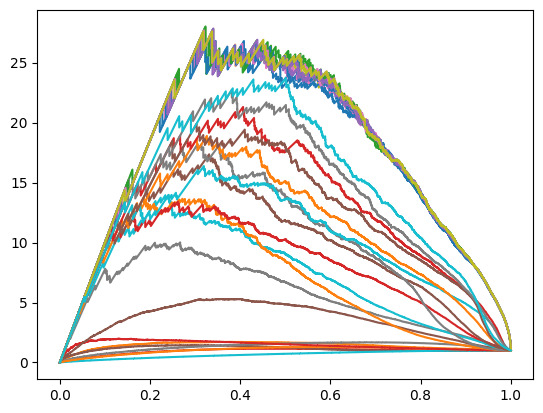

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

qq = 'qq'
noise = False

feature_dims = np.shape(x[0,0,qq, noise])[1]

sig_list = []
weight_list1 = []
weight_list2 = []
weight_list3 = []

msic1 = []
msic2 = []

# w1 = round(random.uniform(0.5, 6.0),3)
# w2 = round(random.uniform(0.5, 6.0),3)
# w1 = 1.367
# w2 = 2.991

w1 = 3.241
w2 = 3.1
print(w1, w2)

for sigfrac in np.logspace(-3,-1,20):
    print(sigfrac)
    #sigfrac = 0.07
    
    # w1 = 2
    # w2 = 5
    
    for l in model_qq.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(feature_dims,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1)
    #LLR_xs = 1.+sigfrac*LLR - sigfrac
    LLR_xs = 1 + model33(tf.ones_like(inputs)[:,0])*LLR
    ws = LLR_xs / (1.+LLR_xs+0.0001)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3
    m2 = 3

    test_background = int(1/2 *len(x[0,0, qq, noise]))
    train_background = int(1/4 * len(x[0,0,qq, noise]))
    train_data = int(1/4 * len(x[0,0,qq, noise]))
    train_reference = int(1/4 * len(x[0,0,qq, noise]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2,qq, noise]))

    N = int(1/4 * len(x[0,0,qq, noise]))
    signal = x[m1,m2,qq, noise][test_signal_length:test_signal_length+int(sigfrac*N)]

    x_data_ = np.concatenate([x[0,0,qq, noise][test_background:],signal])
    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])
    
    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

    with tf.device('/GPU:0'):
        myhistory_hack_ = model_all2.fit(X_train_[:,0:feature_dims], Y_train_, epochs=20,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    sig_list+=[sigfrac]
    weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
    weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
    weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0,qq, noise][0:test_background],x[m1,m2,qq, noise][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)    

    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=feature_dims, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:feature_dims], Y_train_, epochs=10,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)

    scores2 = model_cwola.predict(np.concatenate([x[0,0,qq, noise][0:test_background],x[m1,m2,qq, noise][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr+0.0001))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2+0.0001))

    msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
    msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]

(0.0, 700.0)

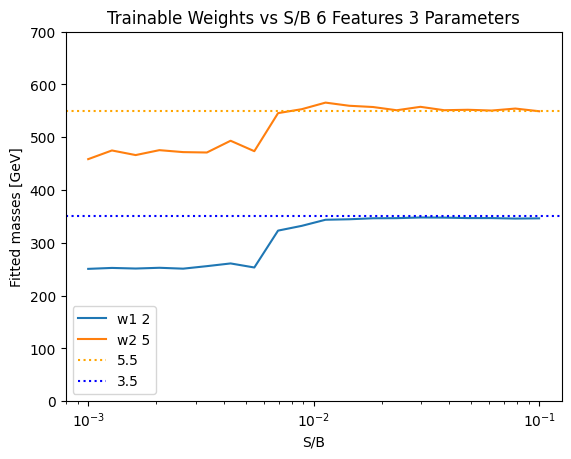

In [212]:
plt.plot(sig_list,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sig_list,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs S/B 6 Features 3 Parameters")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

(0.0, 700.0)

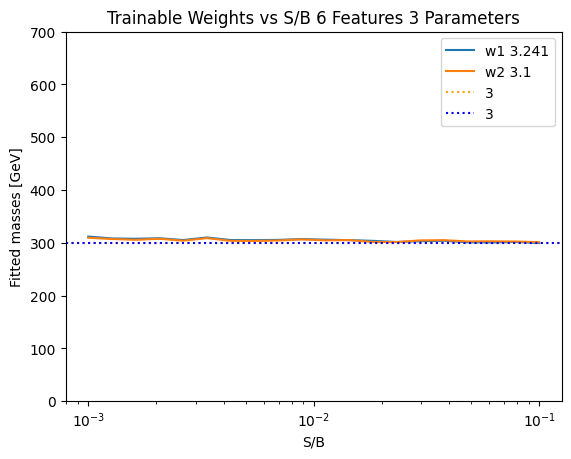

In [14]:
plt.plot(sig_list,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sig_list,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs S/B 6 Features 3 Parameters")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

Text(0, 0.5, 'Fitted S/B')

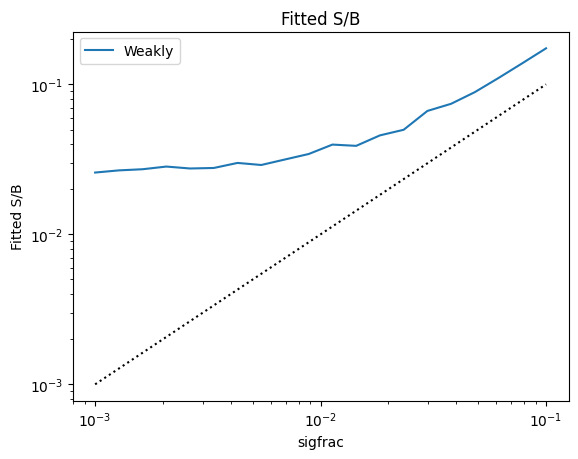

In [214]:
plt.plot(sig_list,weight_list3,label="Weakly")
plt.plot(sig_list,sig_list,ls=":",color="black")

plt.title("Fitted S/B")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("sigfrac")
plt.ylabel("Fitted S/B")

Text(0, 0.5, 'Max SIC')

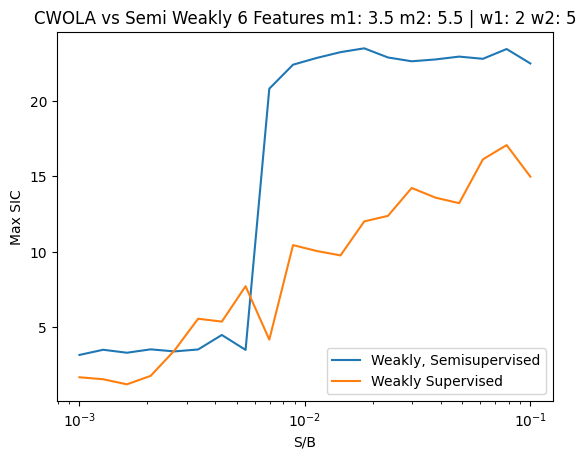

In [213]:
plt.plot(sig_list,msic1,label="Weakly, Semisupervised")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly 6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2}")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Max SIC')

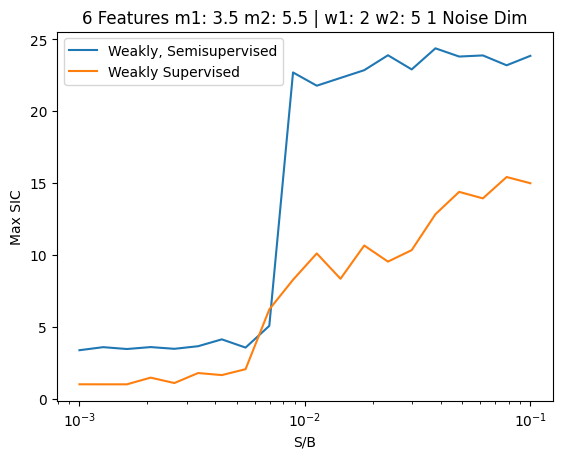

In [455]:
plt.plot(sig_list,msic1,label="Weakly, Semisupervised")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.title(f"6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2} 1 Noise Dim")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Max SIC')

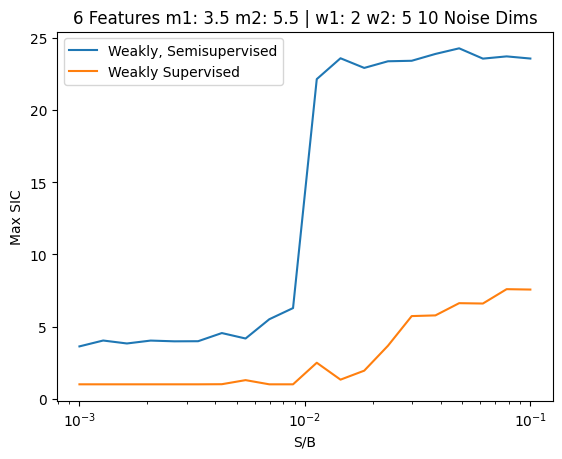

In [39]:
plt.plot(sig_list,msic1,label="Weakly, Semisupervised")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.title(f"6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2} 10 Noise Dims")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

In [4]:
#dedicated training on single mass pair
def train_supervised(feature_dims, m1, m2):
    x_data_full = np.concatenate([x[0,0, qq, noise],x[m1,m2, qq, noise]])
    y_data_full = np.concatenate([np.zeros(len(x[0,0, qq, noise])),np.ones(len(x[m1,m2, qq, noise]))])
    X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(x_data_full, y_data_full, test_size=0.5, random_state = 42)

    model_dedicated = Sequential()
    model_dedicated.add(Dense(128, input_dim=feature_dims, activation='relu'))
    model_dedicated.add(Dense(128, activation='relu'))
    model_dedicated.add(Dense(128, activation='relu'))
    model_dedicated.add(Dense(1, activation='sigmoid'))
    model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

    history_fullySupervised = model_dedicated.fit(X_train_full, Y_train_full, epochs=100,validation_data=(X_val_full, Y_val_full),batch_size=1024, verbose = 0)
    return model_dedicated

#CWOLA comparison
def compileCWOLA(feature_dims, m1, m2):
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=feature_dims, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_cwola

from tensorflow.keras.constraints import Constraint
class WeightConstraint(Constraint):
    def __init__(self, min_value=0.5, max_value=6):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, weights):
        return tf.clip_by_value(weights, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value, 'max_value': self.max_value}

#SemiWeak Model
def compileSemiWeakly(feature_dims, params, m1, m2, w1, w2):
    
    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1), kernel_constraint=WeightConstraint())(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2), kernel_constraint=WeightConstraint())(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(feature_dims,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])

    #physics prior
    hidden_layer_1 = model_qq(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)

    if params == 2:
        LLR_xs = 1.+sigfrac*LLR - sigfrac
    elif params == 3:
        LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR
    else:
        print("Choose 2 or 3 parameters")
    ws = LLR_xs / (1.+LLR_xs)

    SemiWeakModel = Model(inputs = inputs, outputs = ws)
    SemiWeakModel.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))
    return SemiWeakModel

In [24]:
weight_list = [(2.842, 3.906),
 (2.813, 5.284),
 (2.209, 4.506),
 (3.628, 1.441),
 (5.289, 2.127)]

In [13]:
# from models import createSimpleModel
# qq = "qq"

# msic1_runs = []
# msic2_runs = []
# msic3_runs = []
# msic4_runs = []
# weight_list3_runs = []
# initial_weights_list_runs = []

# num_runs = 5
# noise = False
# feature_dims = np.shape(x[0,0,qq, noise])[1]

# epsilon = 1e-4

# count = 0

# m1 = 2
# m2 = 5

# model_full = train_supervised(feature_dims, m1, m2)
# for _ in range(num_runs):
    
#     #w1, w2 = weight_list[count][0], weight_list[count][1]
    
#     #count+=1
    
#     sig_list = []
#     weight_list1 = []
#     weight_list2 = []
#     weight_list3 = []
    
#     msic1 = []
#     msic2 = []
#     msic3 = []
#     msic4 = []

#     w1 = round(random.uniform(0.5, 6.0),3)
#     w2 = round(random.uniform(0.5, 6.0),3)
    
# #     w1 = 3.241
# #     w2 = 3.649
    
#     initial_weights_list_runs.append((w1, w2))

#     for sigfrac in np.logspace(-3,-1,20):
#         print(w1, w2, sigfrac)
#         #sigfrac = 0.05

#         for l in model_qq.layers:
#             l.trainable=False

#         inputs_hold = tf.keras.Input(shape=(1,))
#         simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
#         model3 = Model(inputs = inputs_hold, outputs = simple_model)

#         inputs_hold2 = tf.keras.Input(shape=(1,))
#         simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
#         model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

#         inputs_hold3 = tf.keras.Input(shape=(1,))
#         simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
#         model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

#         inputs = tf.keras.Input(shape=(feature_dims,))
#         inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        
#         #physics prior
#         hidden_layer_1 = model_qq(inputs2)
#         LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        
#         #LLR_xs = 1.+sigfrac*LLR - sigfrac
#         LLR_xs = 1.+ model33(tf.ones_like(inputs)[:,0])*LLR
#         ws = LLR_xs / (1.+LLR_xs)
        
#         model_all2 = Model(inputs = inputs, outputs = ws)
#         model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

#         m1 = m1
#         m2 = m2

#         test_background = int(1/2 * len(x[0,0, qq, noise]))
#         train_reference = int(1/4 *len(x[0,0, qq, noise]))
#         train_data = int(1/4 * len(x[0,0, qq, noise]))
#         test_signal = int(1/2*len(x[m1,m2, qq, noise]))
    
#         #randomized signal
#         random_test_signal_length = random.randint(0, test_signal - 1)
#         N = int(1/4 * (len(x[0,0, qq, noise])))
#         signal = x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]
        
#         #fixed signal portion
#         # N = int(1/4 * (len(x[0,0, qq, noise])))
#         # signal = x[m1, m2, qq, noise][test_signal:test_signal + int(sigfrac*N)]

#         x_data_ = np.concatenate([x[0,0, qq, noise][test_background:],signal])
#         y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

#         X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

#         myhistory_hack_ = model_all2.fit(X_train_[:,0:feature_dims], Y_train_, epochs=100,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)
#         print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
#         sig_list+=[sigfrac]
#         weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
#         weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
#         weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
#         scores = model_all2.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
#         y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
#         fpr, tpr, _ = metrics.roc_curve(y, scores)
        
#         #weakly supervised
#         model_cwola = Sequential()
#         model_cwola.add(Dense(128, input_dim=feature_dims, activation='relu'))
#         model_cwola.add(Dense(128, activation='relu'))
#         model_cwola.add(Dense(128, activation='relu'))
#         model_cwola.add(Dense(1, activation='sigmoid'))
#         model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#         myhistory_cwola = model_cwola.fit(X_train_[:,0:feature_dims], Y_train_, epochs=10,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)

#         scores2 = model_cwola.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
#         y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
#         fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        
#         #fully supervised
#         scores_full = model_full.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
#         y_full = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
#         fpr_full, tpr_full, _ = metrics.roc_curve(y_full, scores_full)
        
#         #parametrized for comparison
#         scores_full2 = model_qq.predict(x_data_qq[np.product(x_data_qq[:,6:8]==[m1,m2],axis=1)==1],batch_size=1000)
#         fpr_full2, tpr_full2, _ = metrics.roc_curve(y_data_qq[np.product(x_data_qq[:,6:8]==[m1,m2],axis=1)==1], scores_full2)
        
#         msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
#         msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])
#         msic3.append([np.max(tpr_full/np.sqrt(fpr_full+0.0001))])
#         msic4.append([np.max(tpr_full2/np.sqrt(fpr_full2+0.0001))])

#     msic1_runs.append(msic1)
#     msic2_runs.append(msic2)
#     msic3_runs.append(msic3)
#     msic4_runs.append(msic4)
#     weight_list3_runs.append(weight_list3)

5.14 3.139 0.001
2 5 4.655585 2.419061
193/193 [==============================] - 0s 780us/step
5.14 3.139 0.0012742749857031334
2 5 4.8451533 2.3520691
193/193 [==============================] - 0s 803us/step
5.14 3.139 0.001623776739188721
2 5 4.750054 2.3673835
193/193 [==============================] - 0s 781us/step
5.14 3.139 0.00206913808111479
2 5 4.8608913 2.1011186
193/193 [==============================] - 0s 812us/step
5.14 3.139 0.0026366508987303583


KeyboardInterrupt: 

In [68]:
#weight intialization from previous run
weight_list1 = [(0.847, 1.712),
(4.73, 2.808),
(2.293, 2.078),
(2.615, 4.779),
(4.768, 1.88),
(0.749, 3.246),
(1.404, 3.577),
(4.128, 0.759),
(2.162, 4.059),
(2.02, 3.838)]

weight_list2 = [(4.405, 1.865),
 (3.346, 1.344),
 (4.074, 4.702),
 (3.938, 4.059),
 (4.565, 3.05),
 (3.178, 1.314),
 (1.516, 2.081),
 (5.096, 3.04),
 (4.748, 3.198),
 (3.34, 1.061)]

In [9]:
#Loop over signal injection amounts M
#For a given signal injection amount, inject events according to N ~ Poission(M)
#For a given N injected events, initialize the network with w ~ Uniform.  Do this k times.

qq = "qq"

epsilon = 1e-4
k_runs = 5
noise = False
feature_dims = 6
params = 3

m1 = 2
m2 = 5

msic1_runs = []
msic2_runs = []
# msic3_runs = []
# msic4_runs = []

weight_list1_runs = []
weight_list2_runs = []
weight_list3_runs = []
initial_weights_runs = []

model_full = train_supervised(feature_dims, m1, m2)

sigspace = [np.logspace(-3,-1,10)[-1]]
for sigfrac in sigspace:
        
    msic1 = []
    msic2 = []
    # msic3 = []
    # msic4 = []
    
    weight_list1 = []
    weight_list2 = []
    weight_list3 = []
    
    initial_weights = []

    print(f"Ensembling {k_runs} for Signal Fraction : {sigfrac}")
    for k in range(k_runs):
        
        w1 = round(random.uniform(0.5, 6),3)
        w2 = round(random.uniform(0.5, 6),3)
        initial_weights.append((w1, w2))
        print(w1, w2)

        model_semiweak = compileSemiWeakly(feature_dims, params, m1, m2, w1, w2)

        test_background = int(1/2 * len(x[0,0, qq, noise]))
        train_reference = int(1/4 *len(x[0,0, qq, noise]))
        train_data = int(1/4 * len(x[0,0, qq, noise]))
        test_signal = int(1/2*len(x[m1,m2, qq, noise]))

        #randomized signal
        # random_test_signal_length = random.randint(0, test_signal - 1)
        # N = int(1/4 * (len(x[0,0, qq, noise])))
        # signal = x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]
        
        #fixed signal portion
        N = int(1/4 * (len(x[0,0, qq, noise])))
        signal = x[m1, m2, qq, noise][test_signal:test_signal + int(sigfrac*N)]

        x_data_ = np.concatenate([x[0,0, qq, noise][test_background:],signal])
        y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

        history_semiweak = model_semiweak.fit(X_train_[:,0:feature_dims], Y_train_, epochs=100,
                                               validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)
        
        print(m1,m2,model_semiweak.trainable_weights[0].numpy()[0][0],
              model_semiweak.trainable_weights[1].numpy()[0][0])
        
        weight_list1+=[model_semiweak.trainable_weights[0].numpy()[0][0]]
        weight_list2+=[model_semiweak.trainable_weights[1].numpy()[0][0]]
        weight_list3+=[np.exp(model_semiweak.trainable_weights[2].numpy()[0][0])]
        scores = model_semiweak.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        #weakly supervised
        model_cwola = compileCWOLA(feature_dims, m1, m2)
        myhistory_cwola = model_cwola.fit(X_train_[:,0:feature_dims], Y_train_, epochs=10,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        
        #fully supervised dedicated training initiaized once (this still predicts for every s/b can be simplified)
        if k == 0:
            scores_full = model_full.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
            y_full = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
            fpr_full, tpr_full, _ = metrics.roc_curve(y_full, scores_full)

        #parametrized classifer
            scores_full2 = model_qq.predict(x_data_qq[np.product(x_data_qq[:,6:8]==[m1,m2],axis=1)==1],batch_size=1000)
            fpr_full2, tpr_full2, _ = metrics.roc_curve(y_data_qq[np.product(x_data_qq[:,6:8]==[m1,m2],axis=1)==1], scores_full2)
        
        msic1.append(np.max(tpr/np.sqrt(fpr+epsilon)))
        msic2.append(np.max(tpr2/np.sqrt(fpr2+epsilon)))
        # msic3.append(np.max(tpr_full/np.sqrt(fpr_full+epsilon)))
        # msic4.append(np.max(tpr_full2/np.sqrt(fpr_full2+epsilon)))
        
    msic1_runs.append(msic1)
    msic2_runs.append(msic2)
    # msic3_runs.append(msic3)
    # msic4_runs.append(msic4)

    weight_list1_runs.append(weight_list1)
    weight_list2_runs.append(weight_list2)
    weight_list3_runs.append(weight_list3)
    initial_weights_runs.append(initial_weights)

Ensembling 5 for Signal Fraction : 0.1
3.968 3.487
2 5 4.9933777 2.0158255
95/95 [==============================] - 0s 610us/step


NameError: name 'x_data_qq' is not defined

In [126]:
# import math
# poisson = lambda l, k : (l**k * np.exp(l))/(math.factorial(k))
# sig_space = np.logspace(-3,-1,10)

# points = []
# for sigfrac in sig_space:
#     random_test_signal_length = random.randint(0, test_signal - 1)
#     N = int(1/4 * (len(x[0,0, qq, noise])))
#     signal = x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]
#     points.append(poisson(len(signal), len(sig_space)))
    
# plt.plot(sig_space,points)

In [137]:
initial_weights

[(4.405, 1.865),
 (3.346, 1.344),
 (4.074, 4.702),
 (3.938, 4.059),
 (4.565, 3.05),
 (3.178, 1.314),
 (1.516, 2.081),
 (5.096, 3.04),
 (4.748, 3.198),
 (3.34, 1.061)]

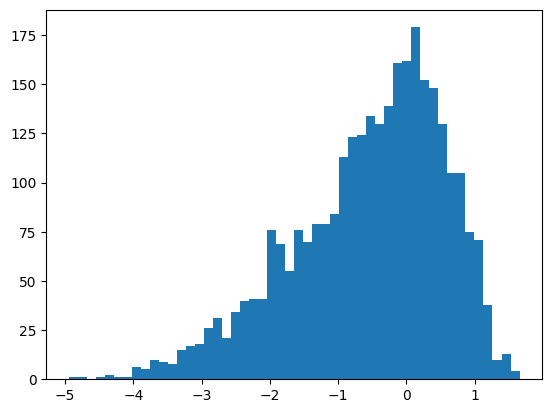

In [56]:
plt.hist(x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)][:,5], bins = 50);

In [49]:
len(x[m1, m2, qq, noise][random_test_signal_length:random_test_signal_length + int(sigfrac*N)][:,0])

3033

Text(0, 0.5, 'Avg Max SIC')

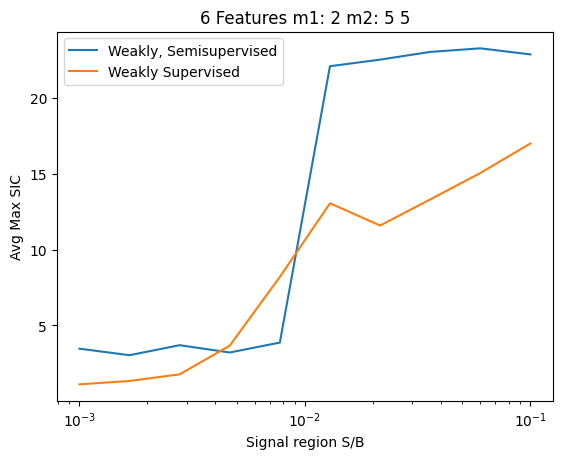

In [135]:
avgmsic1 = np.median(msic1_runs, axis = 1)
avgmsic2 = np.median(msic2_runs, axis = 1)
# avgmsic3 = np.median(msic3_runs, axis = 1)
# avgmsic4 = np.median(msic4_runs, axis = 1)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
# plt.plot(sig_list,avgmsic3,label="Fully Supervised")
# plt.plot(sig_list,avgmsic4,label="Fully Supervised")

plt.title(f"6 Features m1: {m1} m2: {m2} {k_runs}")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

Text(0, 0.5, 'Avg Max SIC')

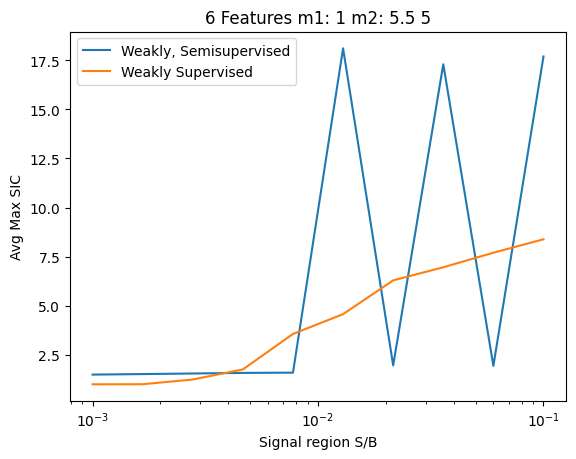

In [23]:
sig_list = np.logspace(-3,-1,10)
avgmsic1 = np.median(msic1_runs, axis = 1)
avgmsic2 = np.median(msic2_runs, axis = 1)
# avgmsic3 = np.median(msic3_runs, axis = 1)
# avgmsic4 = np.median(msic4_runs, axis = 1)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
# plt.plot(sig_list,avgmsic3,label="Fully Supervised")
# plt.plot(sig_list,avgmsic4,label="Fully Supervised")

plt.title(f"6 Features m1: {m1} m2: {m2} {k_runs}")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

Text(0, 0.5, 'Avg Max SIC')

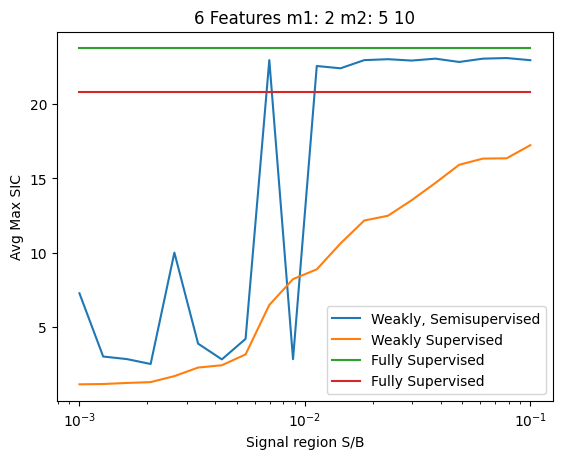

In [17]:
sig_list = np.logspace(-3,-1,20)
avgmsic1 = np.median(msic1_runs, axis = 1)
avgmsic2 = np.median(msic2_runs, axis = 1)
avgmsic3 = np.median(msic3_runs, axis = 1)
avgmsic4 = np.median(msic4_runs, axis = 1)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.plot(sig_list,avgmsic4,label="Fully Supervised")

plt.title(f"6 Features m1: {m1} m2: {m2} {k_runs}")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

In [18]:
max_sics = {}
max_sics[("SWS", feature_dims, len(model_semiweak.trainable_weights), m1, m2)] = msic1_runs
max_sics[("WS", feature_dims, len(model_semiweak.trainable_weights), m1, m2)] = msic2_runs
max_sics[("FS", feature_dims, len(model_semiweak.trainable_weights), m1, m2)] = msic3_runs
max_sics[("FP", feature_dims, len(model_semiweak.trainable_weights), m1, m2)] = msic4_runs

import pickle
with open('max_sics25loopstructure5.pkl', 'wb') as f:
    pickle.dump(max_sics, f)

In [79]:
np.save("25loopstructure2.npy", weight_list3_runs)

In [223]:
import time

#3pronged decay
qq = "qq"
start_time = time.time()

def create_loss_landscape_6Features(feature_dims, parameters, m1, m2):
    
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"z_allm1m2_{feature_dims}morefps33.5.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    #varying sigfrac, fixed mass pair
    
    losses_list = []

    epsilon = 1e-4
    sig_space = np.logspace(-3, -1, 20)
    
    #if we want a specific sigfrac
    #sig_space = [0.1]
    
    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
        print("Signal Fraction: ", sig)
        count = 0
        for w1 in weight_list:
            for w2 in weight_list:
                if count % 1000 == 0:
                    print(f"reached {w1} {w2}")
                count+=1
                #print(w1, w2)
                sigfrac = sig

                model_semiweak = compileSemiWeakly(feature_dims, parameters, m1, m2, w1, w2)

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                
                key = (sigfrac,m1,m2)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0, qq]))
                train_background = int(1/4 * len(x[0,0,qq]))
                train_data = int(1/4 * len(x[0,0,qq]))
                train_reference = int(1/4 * len(x[0,0,qq]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq]))
                sig_frac = sigfrac

                #randomize signal events
                random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq])))
                signal = x[m1, m2,qq][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0,qq][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)
                
                with tf.device('/GPU:0'):
                    loss = model_semiweak.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z[sigfrac, m1, m2] = losses_list
            losses_list = []
            np.save(file_name, z)
end_time_total = time.time()

elapsed_time_total = round(end_time_total - start_time, 3)
print(f"Total elapsed time: {elapsed_time_total} seconds")

Total elapsed time: 0.001 seconds


In [ ]:
create_loss_landscape_6Features(model_qq, 2, 5)

Signal Fraction:  0.001
Time taken: 29769.496 seconds
Signal Fraction:  0.0012742749857031334
Time taken: 30525.919 seconds
Signal Fraction:  0.001623776739188721
Time taken: 31285.205 seconds
Signal Fraction:  0.00206913808111479
Time taken: 32070.743 seconds
Signal Fraction:  0.0026366508987303583
Time taken: 32950.64 seconds
Signal Fraction:  0.003359818286283781
Time taken: 33757.107 seconds
Signal Fraction:  0.004281332398719396
Time taken: 34478.88 seconds
Signal Fraction:  0.00545559478116852
Time taken: 35191.248 seconds
Signal Fraction:  0.0069519279617756054
Time taken: 35904.252 seconds
Signal Fraction:  0.008858667904100823
Time taken: 36614.143 seconds
Signal Fraction:  0.011288378916846888
Time taken: 37497.193 seconds
Signal Fraction:  0.01438449888287663


In [23]:
z_allm1m2_HD = np.load("z_allm1m2_6FeaturesHD.npy", allow_pickle = True).item()
z_allm1m2_HD.keys()

dict_keys([(0.0379269019073225, 3, 4.5), (0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5)])

In [31]:
from IPython.display import display, clear_output
from PIL import Image, ImageSequence
def create_gif_nofit(m1, m2, z):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sig_space = np.logspace(-3, -1 , 20)
    
    frames = []
    for sb in sig_space:
    
        loss_landscape_nofit(sb, m1, m2, z)

        image_path = os.path.join(output_directory, f'hist_{sb}.png')
        plt.savefig(image_path)
        plt.close()
        clear_output(wait=True)

        # Append the image to the frames list
        frames.append(Image.open(image_path))

    # Create the final GIF that combines all frames
    output_gif_filename = f'sigspace{m1}{m2}fixed.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)

In [16]:
X_train_qqq, X_val_qqq, Y_train_qqq, Y_val_qqq = train_test_split(x_data_qqq, y_data_qqq, test_size=0.5)

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [7]:
model_qq = tf.keras.models.load_model("model_qq_v2")
model_qqq = tf.keras.models.load_model("model_qqq")

2024-01-09 21:32:41.982684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 21:32:43.758591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13379 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [202]:
from models import createSimpleModel

decay = "qqq"
qq = "qq"

sigmoid = lambda x: 1. / (1. + np.exp(-x))

msic1_runs = []
msic2_runs = []
msic3_runs = []
weight_list3_runs = []
weight_list4_runs = []
initial_weights_list_runs = []

num_runs = 1

for _ in range(num_runs):

    sig_list = []
    
    msic1 = []
    msic2 = []
    msic3 = []
    weight_list1 = []
    weight_list2 = []
    weight_list3 = []
    weight_list4 = []

    sigspace = np.logspace(-3, -1, 20)

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    initial_weights_list_runs.append((w1, w2))

    #print(w1, w2)
    for sigfrac in sigspace:

        #freeze both two pronged and three pronged prior models
        for l in model_qq.layers:
            l.trainable=False

        for l in model_qqq.layers:
            l.trainable=False

        #sigfrac = 0.1
        print(sigfrac, w1, w2)

        #w1, w2 = 3.241, 3.649 

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs_hold4 = tf.keras.Input(shape=(1,))
        simple_model4 = Dense(1,use_bias = False,activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(1.))(inputs_hold4)
        model34 = Model(inputs = inputs_hold4, outputs = simple_model4)

        inputs = tf.keras.Input(shape=(6,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_qq(inputs2)
        hidden_layer_13 = model_qqq(inputs2)
        LLR2 = hidden_layer_1 / (1.-hidden_layer_1+0.0001)
        LLR3 = hidden_layer_13 / (1.-hidden_layer_13+0.0001)
        #LLR_xs = 1.+ sigfrac*LLR3 - sigfrac
        LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0])
        ws = LLR_xs_fixed / (1.+LLR_xs_fixed+0.0001)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 1
        m2 = 5.5

        test_background = int(1/2 * len(x[0,0, decay]))
        train_reference = int(1/4 *len(x[0,0, decay]))
        train_data = int(1/4 * len(x[0,0, decay]))
        test_signal = int(1/2*len(x[m1,m2, decay]))
        sig_frac = sigfrac

        #randomize signal events
        # random_test_signal_length = random.randint(0, test_signal - 1)
        N = int(1/4 * (len(x[0,0, decay])))
        # signal = x[m1, m2, decay][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        #mix both samples
        signal_mixed = np.concatenate([x[m1, m2, decay][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))], x[m1, m2, qq][int(test_signal/2):int(test_signal/2) + int(sigfrac*(N/2))]])
        background_mixed = np.concatenate([x[0,0,decay][:int(test_background/2)], x[0,0,qq][:int(test_background/2)]])
        
        # x_data_ = np.concatenate([x[0,0,decay][test_background:],signal])
        # y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])
        
        x_data_mixed = np.concatenate([background_mixed,signal_mixed])
        y_data_mixed = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal_mixed))])
        
        #noise?
        # samples = np.shape(x_data_mixed)[0]
        # random_samples = np.random.normal(0, 1, samples)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_mixed, y_data_mixed, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

        sig_list+=[sigfrac]
        weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
        weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
        weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        weight_list4+=[sigmoid(model_all2.trainable_weights[3].numpy()[0][0])]

        #scores = model_all2.predict(np.concatenate([x[0,0, decay][0:test_background],x[m1,m2, decay][0:test_signal]]),batch_size=1024, verbose = 0)
        #scores_mixed = model_all2.predict(x[0,0,decay][0:int(test_background/2)], signal_mixed,batch_size=1024, verbose = 0)
        #y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        #fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        #weakly supervised
        # model_cwola = Sequential()
        # model_cwola.add(Dense(128, input_dim=6, activation='relu'))
        # model_cwola.add(Dense(128, activation='relu'))
        # model_cwola.add(Dense(128, activation='relu'))
        # model_cwola.add(Dense(1, activation='sigmoid'))
        # model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)

        #scores2 = model_cwola.predict(np.concatenate([x[0,0, decay][0:test_background],x[m1,m2, decay][0:test_signal]]),batch_size=1024)
        #scores2_mixed = model_cwola.predict([background_mixed,signal_mixed],batch_size=1024)
        #y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        #fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        
#         #fully supervised
        scores_full = model_dedicated.predict(np.concatenate([x[0,0, qq, noise][0:test_background],x[m1,m2, qq, noise][0:test_signal]]),batch_size=1024)
        y_full = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr_full, tpr_full, _ = metrics.roc_curve(y_full, scores_full)
        
#         msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
#         msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])
#         msic3.append([np.max(tpr_full/np.sqrt(fpr_full+0.0001))])
        
    msic1_runs.append(msic1)
    msic2_runs.append(msic2)
    #msic3_runs.append(msic3)
    weight_list3_runs.append(weight_list3)
    weight_list4_runs.append(weight_list4)

0.001 2.876 4.013


KeyboardInterrupt: 

In [137]:
initial_weights_list_runs

[(3.067, 3.45), (1.705, 4.476), (3.225, 5.053), (5.711, 3.199), (3.922, 2.867)]

In [84]:
np.shape(x[0,0,qq][:int(test_background/2)])

(30338, 6)

In [30]:
x[0,0,qqq][int(test_background/2):]

array([[-1.11881922, -1.66852576,  1.57244427,  1.20983769, -0.13939007,
         0.85941707],
       [-1.12420602, -1.26681214,  0.82536103,  0.1229807 ,  0.30860917,
         0.13311748],
       [-1.14769921, -0.50415523,  1.43958292,  0.62034086,  0.19901901,
        -1.04425623],
       ...,
       [-0.96736856, -1.48238533,  1.25622683, -0.47599974, -0.32423304,
         0.86060971],
       [-1.3598598 , -1.72354998,  1.79953958,  1.20194427,  0.44119858,
         0.28992835],
       [-1.42887276, -1.6890858 ,  0.89151195,  0.58091326,  1.22563292,
         0.4144562 ]])

In [110]:
x[0,0,qq][int(test_background/2):] == x[0,0,qqq][int(test_background/2):]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [35]:
np.array_equal(x[0,0,qq][int(test_background/2):], x[0,0,qqq][int(test_background/2):])

True

In [26]:
int(test_background/2) + int(test_background/2) == test_background

True

In [196]:
np.save("3ProngWeight_List3_Runs33_randomized", weight_list3_runs)
np.save("3ProngWeight_List4_Runs33_randomized", weight_list4_runs)

Text(0, 0.5, 'Avg Max SIC')

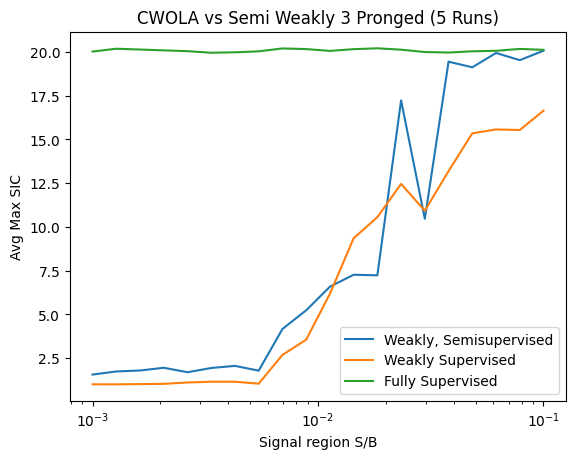

In [202]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly 3 Pronged ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

In [107]:
initial_weights_list_runs

[(3.564, 1.382)]

In [159]:
avgww = np.median(weight_list3_runs, axis = 0)
avgww2 = np.median(weight_list4_runs, axis = 0)

plt.plot(sig_list,weight_list3,label=r"$\mu$")
plt.plot(sig_list,weight_list4,label=r"$\alpha$")
plt.plot(sig_list,sig_list,ls=":",color="black")

plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

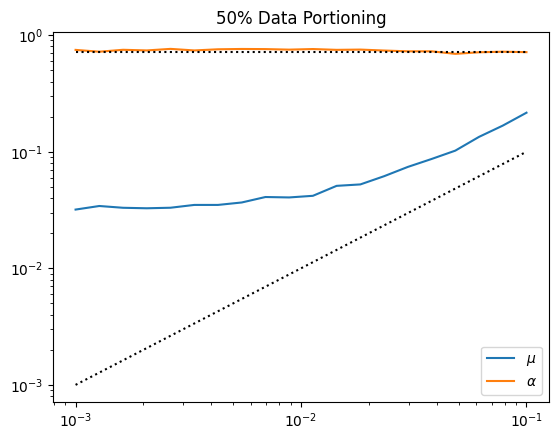

In [142]:
plt.plot(sig_list,weight_list3,label=r"$\mu$")
plt.plot(sig_list,weight_list4,label=r"$\alpha$")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.plot(sig_list, [weight_list4[19]]*20, ls = ":", color = "black")
plt.title("50% Data Portioning")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [161]:
weight_list4

[0.7949729094565375,
 0.7967428042435447,
 0.7633858522721106,
 0.7183202970246372,
 0.7286010241365904,
 0.8059874435095145,
 0.7859716109884602,
 0.7620331165145308,
 0.7544795437582383,
 0.7142845860567203,
 0.7264332030386054,
 0.7649021788557809,
 0.7848433666572873,
 0.7418548081439902,
 0.7345575889763402,
 0.7782074477116568,
 0.8123507782533296,
 0.8373520277157607,
 0.8798965231515105,
 0.8941288071840675]

(0.0, 700.0)

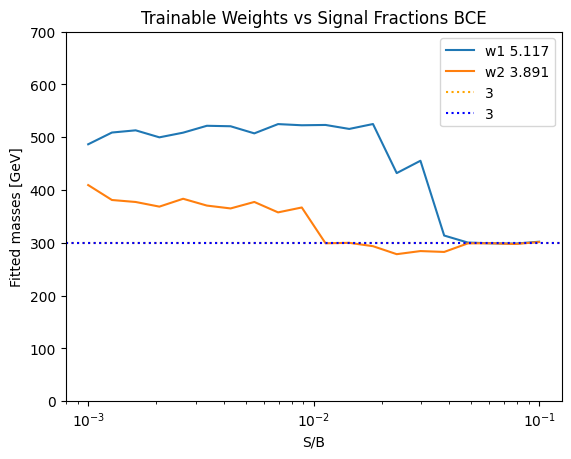

In [205]:
plt.plot(sig_list,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sig_list,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

In [199]:
max_sics = {}
max_sics[("SWS", 6, 4, m1, m2)] = msic1_runs
max_sics[("WS", 6, 4, m1, m2)] = msic2_runs
max_sics[("FS", 6, 4, m1, m2)] = msic3_runs

import pickle
with open('max_sics_3prong33randomized.pkl', 'wb') as f:
    pickle.dump(max_sics, f)

In [21]:
if (True):
    
    model_qqq = Sequential()
    model_qqq.add(Dense(256, input_dim=8, activation='swish'))
    model_qqq.add(BatchNormalization())
    model_qqq.add(Dense(256, activation='swish'))
    model_qqq.add(BatchNormalization())
    model_qqq.add(Dense(256, activation='swish'))
    model_qqq.add(BatchNormalization())
    model_qqq.add(Dense(1, activation='sigmoid'))
    model_qqq.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    myhistory_qqq = model_qqq.fit(X_train_qqq, Y_train_qqq, epochs=500,validation_data=(X_val_qqq, Y_val_qqq),batch_size=5*1024,callbacks=[es])
    
    plt.plot(myhistory_qqq.history['val_loss'][1:])
    plt.plot(myhistory_qqq.history['loss'][1:])
    
    model_qqq.save('model_qqq')

Epoch 1/500
2692/2692 [==============================] - 11s 4ms/step - loss: 0.1674 - accuracy: 0.9340 - val_loss: 0.1564 - val_accuracy: 0.9386
Epoch 2/500
2692/2692 [==============================] - 9s 4ms/step - loss: 0.1542 - accuracy: 0.9391 - val_loss: 0.1539 - val_accuracy: 0.9393
Epoch 3/500
2692/2692 [==============================] - 9s 3ms/step - loss: 0.1530 - accuracy: 0.9396 - val_loss: 0.1529 - val_accuracy: 0.9396
Epoch 4/500
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1523 - accuracy: 0.9398 - val_loss: 0.1525 - val_accuracy: 0.9399
Epoch 5/500
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1518 - accuracy: 0.9400 - val_loss: 0.1517 - val_accuracy: 0.9400
Epoch 6/500
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1514 - accuracy: 0.9402 - val_loss: 0.1511 - val_accuracy: 0.9404
Epoch 7/500
2692/2692 [==============================] - 9s 4ms/step - loss: 0.1511 - accuracy: 0.9403 - val_loss: 0.1517 - va

KeyboardInterrupt: 

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_qqq = Sequential()
model_qqq.add(Dense(256, input_dim=8, activation='swish'))
model_qqq.add(BatchNormalization())
model_qqq.add(Dense(256, activation='swish'))
model_qqq.add(BatchNormalization())
model_qqq.add(Dense(256, activation='swish'))
model_qqq.add(BatchNormalization())
model_qqq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qqq.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_qqq = model_qqq.fit(X_train_qqq, Y_train_qqq, epochs=5000,validation_data=(X_val_qqq, Y_val_qqq),batch_size=5*1024,callbacks=[es])

Epoch 1/5000
2692/2692 [==============================] - 13s 4ms/step - loss: 0.2904 - accuracy: 0.8848 - val_loss: 0.2361 - val_accuracy: 0.9107
Epoch 2/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.2222 - accuracy: 0.9152 - val_loss: 0.2095 - val_accuracy: 0.9189
Epoch 3/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.2026 - accuracy: 0.9209 - val_loss: 0.1963 - val_accuracy: 0.9230
Epoch 4/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1926 - accuracy: 0.9242 - val_loss: 0.1890 - val_accuracy: 0.9256
Epoch 5/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1866 - accuracy: 0.9265 - val_loss: 0.1841 - val_accuracy: 0.9274
Epoch 6/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1824 - accuracy: 0.9281 - val_loss: 0.1803 - val_accuracy: 0.9291
Epoch 7/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1792 - accuracy: 0.9294 - val_loss: 0

KeyboardInterrupt: 

In [56]:
#model_qqq.save('model_qqq')

INFO:tensorflow:Assets written to: model_qqq/assets
